# Imports & global switches

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import gym, torch, h5py
from gym import spaces

# Stable Baselines3
from stable_baselines3 import PPO

# Surrogate model (used inside the env module)
from surrogate_model_gru import SurrogateModel

# Our environment (imported; not defined inline)
from co2storage_env_gru import CO2StorageEnv

%matplotlib inline

# Ensure a Figures/ folder exists for all saved figures
os.makedirs("Figures", exist_ok=True)


# PPO & human evaluation helpers

In [4]:
# Two thin wrappers that roll out a complete 20-step episode and keep per-step logs.
# The env implements the paper’s step logic: t=0 ignore, t=1 set locations+r(t=1),
# t=2..14 set rates only, t=15..19 post-injection (no rates).

def evaluate_ppo(env, model, sample_idx=0):
    obs = env.reset(sample_idx=sample_idx)
    done = False
    total_reward = 0.0
    step_info, ppo_actions = [], []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        ppo_actions.append(action.copy())
        obs, reward, done, info = env.step(action)
        total_reward += reward
        step_info.append({
            "Step": env.current_step,                # 1..20
            "RealRates": info["real_rates"],         # physical Mt/year
            "Reward": reward,
            "MaxPressure": info["max_pressure"],     # kPa
            "PressurePenalty": info["pressure_penalty"],
            "LeakagePenalty": info["leakage_penalty"],
            "WellLocations": info["well_locations"]  # list of (y,x) or None
        })
    return total_reward, step_info, ppo_actions


def evaluate_human_config(env, sample_idx=0, config=None):
    """
    config: list of three (y,x) grid coords, e.g. [(30,30),(20,40),(40,40)]
    A constant normalized rate (0.33 ≈ 1 Mt/year) is used for reproducibility.
    """
    obs = env.reset(sample_idx=sample_idx)
    done = False
    total_reward = 0.0
    step_info, human_actions = [], []

    if config is None:
        config = [(30,30), (20,40), (40,40)]

    def norm_xy(v, sz=60): return v/(sz-1)
    (y1,x1), (y2,x2), (y3,x3) = config
    action = np.array([norm_xy(x1), norm_xy(y1),
                       norm_xy(x2), norm_xy(y2),
                       norm_xy(x3), norm_xy(y3),
                       0.33, 0.33, 0.33], dtype=np.float32)

    while not done:
        obs, reward, done, info = env.step(action)
        total_reward += reward
        human_actions.append(action.copy())
        step_info.append({
            "Step": env.current_step,
            "RealRates": info["real_rates"],
            "Reward": reward,
            "MaxPressure": info["max_pressure"],
            "PressurePenalty": info["pressure_penalty"],
            "LeakagePenalty": info["leakage_penalty"],
            "WellLocations": info["well_locations"]
        })
    return total_reward, step_info, human_actions


# Human Location Configurations

In [5]:
# Eight pre-defined location triplets (W1, W2, W3) for ablation/benchmarking.
# These match the paper’s “human” placements sweep.

location_configurations = [
    [(30, 30), (20, 40), (20, 20)],
    [(15, 15), (44, 33), (15, 45)],
    [(20, 40), (30, 30), (40, 20)],
    [(20, 20), (30, 30), (40, 40)],
    [(20, 30), (30, 30), (40, 30)],
    [(12, 48), (30, 12), (48, 48)],
    [(29, 13), (47, 37), (12, 43)],
    [(37, 12), (47, 38), (19, 47)],
]
NUM_CONFS = len(location_configurations)


# Plot: PPO vs individual human configs (per sample)

In [6]:
# Scatter each human config’s total reward and overlay PPO as a line.
# X-axis shows sample row index for a compact “per-realization” overview.

def plot_all_configs(df_summary):
    x_vals        = df_summary.index + 1
    sample_labels = df_summary["SampleIndex"]

    plt.figure(figsize=(10, 6))
    human_markers = ['^','s','D','v','*','P','X','h'][:NUM_CONFS]
    for i, m in enumerate(human_markers, start=1):
        col = f"Conf{i}_Reward"
        if col in df_summary.columns:
            plt.plot(x_vals, df_summary[col],
                     linestyle='None', marker=m, markersize=8, alpha=0.8,
                     label=f"Conf{i}")

    plt.plot(x_vals, df_summary["PPO_Reward"],
             marker='o', linestyle='-', color='black', linewidth=2,
             markersize=6, label="PPO")

    plt.xticks(x_vals, sample_labels, rotation=45)
    plt.xlabel("Row (Sample Index in df)")
    plt.ylabel("Total Reward (20 steps)")
    plt.grid(True, alpha=0.25); plt.legend()
    plt.tight_layout(); plt.show()


# Plot: 3×5 fields (Porosity, Saturation, Pressure) at key years

In [7]:
# 20 steps ≈ 56 years. We show years 1,10,20,30,56 taken from steps [0,5,10,14,19].
# Pressure color range set to 35–45 MPa.

import matplotlib.gridspec as gridspec

def plot_threefields_5cols(env, sample_idx, label="",
                           use_ppo=False, model=None, config=None, layer_to_show=10):

    obs       = env.reset(sample_idx=sample_idx)
    max_steps = env.max_time
    por_3d    = env.static_data["Por"]

    sat_list, pres_list, wells_list = [], [], []

    # fixed "human" action (locations + constant rate)
    action_config = None
    if (not use_ppo) and (config is not None):
        def norm_xy(v, size=60): return v / (size - 1)
        (y1, x1), (y2, x2), (y3, x3) = config
        action_config = np.array([norm_xy(x1), norm_xy(y1),
                                  norm_xy(x2), norm_xy(y2),
                                  norm_xy(x3), norm_xy(y3),
                                  0.33, 0.333, 0.333], dtype=np.float32)

    for step_i in range(max_steps):
        action = (model.predict(obs, deterministic=True)[0]
                  if (use_ppo and model is not None) else action_config)
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            # pad if episode ends early
            for _ in range(step_i + 1, max_steps):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    chosen_steps = [0, 5, 10, 14, 19]
    step_to_year = {0: 1, 5: 10, 10: 20, 14: 30, 19: 56}
    well_labels  = ["W1", "W2", "W3"]

    fig = plt.figure(figsize=(14, 8))
    gs  = gridspec.GridSpec(3, 5, wspace=0.08, hspace=0.15)

    for col_i, st in enumerate(chosen_steps):
        year  = step_to_year[st]
        wlist = wells_list[st]

        # Row 1: Porosity
        ax_por = plt.subplot(gs[0, col_i])
        ax_por.imshow(por_3d[layer_to_show], origin="lower", cmap="viridis")
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax_por.scatter(wx, wy, s=40, edgecolor="black")
                ax_por.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=8)
        ax_por.set_title(f"Year {year}  (Porosity)", fontsize=9)
        ax_por.set_xticks([]); ax_por.set_yticks([])

        # Row 2: Saturation
        ax_sat = plt.subplot(gs[1, col_i])
        ax_sat.imshow(sat_list[st][layer_to_show], origin="lower",
                      cmap="jet", vmin=0, vmax=1)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax_sat.scatter(wx, wy, s=40, edgecolor="black")
                ax_sat.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=8)
        ax_sat.set_title(f"Year {year}  (Saturation)", fontsize=9)
        ax_sat.set_xticks([]); ax_sat.set_yticks([])

        # Row 3: Pressure (kPa values, MPa labels)
        ax_pre = plt.subplot(gs[2, col_i])
        im = ax_pre.imshow(pres_list[st][layer_to_show], origin="lower",
                           cmap="jet", vmin=35000, vmax=45000)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax_pre.scatter(wx, wy, s=40, edgecolor="black")
                ax_pre.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=8)
        ax_pre.set_title(f"Year {year}  (Pressure, MPa)", fontsize=9)
        ax_pre.set_xticks([]); ax_pre.set_yticks([])

    plt.show()


# Plot: injection-rate history (PPO vs best human)

In [8]:
# Compares rates only during the injection window (steps 1..14 ≈ years 0..30).
# Y axis in Mt/year. The time axis (years) is linear in the discretization.

def plot_step_rates(ppo_steps, best_steps, label_best="BestHuman",
                    inj_period_steps=14, last_year=30):

    def filter_steps(steps):
        return sorted([st for st in steps if 1 <= st["Step"] <= inj_period_steps+1],
                      key=lambda s: s["Step"])

    ppo_f, best_f = filter_steps(ppo_steps), filter_steps(best_steps)

    scale = last_year / inj_period_steps
    px = [(st["Step"] - 1) * scale for st in ppo_f]
    bx = [(st["Step"] - 1) * scale for st in best_f]

    p_r1, p_r2, p_r3 = zip(*[st["RealRates"] for st in ppo_f])
    b_r1, b_r2, b_r3 = zip(*[st["RealRates"] for st in best_f])

    plt.figure(figsize=(8,5))
    # PPO
    plt.step(px, p_r1, where="post", label="PPO_W1")
    plt.step(px, p_r2, where="post", label="PPO_W2")
    plt.step(px, p_r3, where="post", label="PPO_W3")
    # Best human
    plt.step(bx, b_r1, where="post", label=f"{label_best}_W1", linestyle="--")
    plt.step(bx, b_r2, where="post", label=f"{label_best}_W2", linestyle="--")
    plt.step(bx, b_r3, where="post", label=f"{label_best}_W3", linestyle="--")

    plt.xticks(np.arange(0, last_year+1, 2))
    plt.xlabel("Year")
    plt.ylabel("Injection Rate (Mt/year)")
    plt.title(f"Injection History: PPO vs. {label_best} (0–{last_year} years)")
    plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout(); plt.show()


# Main experiment loop (summary + detail CSV, overview plots)

In [ ]:

# Runs PPO vs. 8 human configs on the requested samples.
# Produces summary.csv (per-sample totals) and detail.csv (per-step logs for top delta).

def main_comparison_and_usage(
    model_path="./trained_models/ppo_co2storage_final_seed_1",
    data_path="valid_data.h5",
    bulk_data_path="BulkVolume.h5",
    feasible_map_path="robust_feasible_map_3d_gaussian_smoothed.npy",
    max_time=20,
    sample_list=None,
    random_seed=42
):
    if sample_list is None: sample_list = [0]

    env = CO2StorageEnv(max_time=max_time,
                        data_path=data_path,
                        bulk_data_path=bulk_data_path,
                        feasible_map_path=feasible_map_path)
    env.seed(random_seed)

    model = PPO.load(model_path, device="cpu")

    summary_records = []

    for sample_idx in sample_list:
        ppo_reward, ppo_steps, _ = evaluate_ppo(env, model, sample_idx)

        conf_rewards, conf_steps_list = [], []
        for i, config in enumerate(location_configurations, start=1):
            c_reward, c_steps, _ = evaluate_human_config(env, sample_idx, config)
            conf_rewards.append(c_reward)
            conf_steps_list.append((i, c_reward, c_steps))

        best_predef = max(conf_rewards)
        diff_val    = ppo_reward - best_predef

        row = {"SampleIndex": sample_idx,
               "PPO_Reward": ppo_reward,
               "Best_Predef": best_predef,
               "Difference": diff_val}
        for i, r_val in enumerate(conf_rewards, start=1):
            row[f"Conf{i}_Reward"] = r_val
        summary_records.append(row)

        print(f"[Sample={sample_idx}] PPO={ppo_reward:.4f}  "
              f"BestHuman={best_predef:.4f}  Diff={diff_val:.4f}")

    df_summary = pd.DataFrame(summary_records)
    df_summary_sorted = df_summary.sort_values("Difference", ascending=False, ignore_index=True)
    df_summary_sorted.to_csv("summary.csv", index=False)
    print("Saved => summary.csv")

    # multi-line chart (expect Conf1..Conf8)
    needed_cols = ["PPO_Reward"] + [f"Conf{i}_Reward" for i in range(1, 9)]
    if all(col in df_summary_sorted.columns for col in needed_cols):
        plot_all_configs(df_summary_sorted)

    # focus the sample with the highest PPO–human gap
    top_row    = df_summary_sorted.iloc[0]
    top_sample = int(top_row["SampleIndex"])
    print(f"\nHighest difference => sample={top_sample}, diff={top_row['Difference']:.3f}")

    # per-step export for PPO and best human config on that sample
    ppo_reward, ppo_steps, _ = evaluate_ppo(env, model, top_sample)

    conf_rewards = []
    conf_steps_list = []
    for i, conf in enumerate(location_configurations, start=1):
        c_reward, c_steps, _ = evaluate_human_config(env, top_sample, conf)
        conf_rewards.append(c_reward); conf_steps_list.append((i, c_reward, c_steps))

    best_idx = int(np.argmax(conf_rewards)) + 1
    best_cfg = location_configurations[best_idx - 1]
    best_steps = [x for x in conf_steps_list if x[0] == best_idx][0][2]
    print(f"BestHuman = {max(conf_rewards):.3f} => Conf{best_idx}")

    # make a tidy CSV
    def tidy_records(steps, approach_name):
        out = []
        for st in steps:
            rr = [round(x,3) for x in st["RealRates"]]
            out.append({
                "SampleIndex": top_sample, "Approach": approach_name,
                "Timestep": st["Step"], "Reward": st["Reward"],
                "MaxPressure": st["MaxPressure"], "PressurePenalty": st["PressurePenalty"],
                "LeakagePenalty": st["LeakagePenalty"], "WellLocations": st["WellLocations"],
                "RealRates": rr
            })
        return out

    detail_records = []
    detail_records += tidy_records(ppo_steps, "PPO")
    detail_records += tidy_records(best_steps, f"Conf{best_idx}")

    df_detail = pd.DataFrame(detail_records).sort_values(["Approach","Timestep"]).reset_index(drop=True)
    df_detail.to_csv("detail.csv", index=False)
    print("Saved => detail.csv (highest-diff sample only).")

    # diagnostic plots
    plot_step_rates(ppo_steps, best_steps, label_best=f"Conf{best_idx}")
    print("\nPlotting 3×5 fields => PPO ...")
    plot_threefields_5cols(env, top_sample, label="PPO", use_ppo=True, model=model)
    print(f"\nPlotting 3×5 fields => Conf{best_idx} ...")
    plot_threefields_5cols(env, top_sample, label=f"Conf{best_idx}", use_ppo=False, config=best_cfg)
    print("\nDONE.\n")


In [ ]:
if __name__ == "__main__":
    MODEL_PATH = "./trained_models/ppo_co2storage_final_seed_1"
    DATA_PATH  = "valid_data.h5"
    BULK_DATA_PATH = "BulkVolume.h5"
    FEASIBLE_MAP_PATH = "robust_feasible_map_3d_gaussian_smoothed.npy"

    samples_to_compare = range(20)

    main_comparison_and_usage(
        model_path=MODEL_PATH,
        data_path=DATA_PATH,
        bulk_data_path=BULK_DATA_PATH,
        feasible_map_path=FEASIBLE_MAP_PATH,
        max_time=20,
        sample_list=samples_to_compare,
        random_seed=42
    )


    

# PPO vs CMA-ES vs human (per sample)

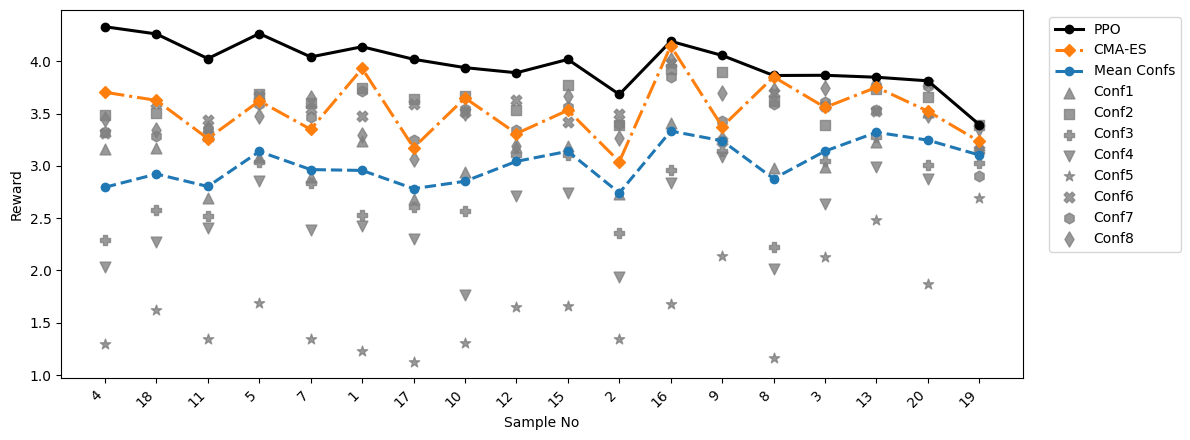

In [17]:
# Reproduces the performance comparison figure. Joins summary.csv with CMA-ES log.
# Pressure/units are not used here; we plot rewards only.

import pathlib as _pl
import matplotlib.pyplot as plt

df = pd.read_csv("summary.csv")
fname_cma = "cma_live_log.csv"
df_cma = (pd.read_csv(fname_cma, usecols=["Sample","Reward"])
            .rename(columns={"Sample":"SampleIndex","Reward":"CMA_Reward"}))
df = df.merge(df_cma, on="SampleIndex", how="left")

conf_cols = [f"Conf{i}_Reward" for i in range(1, 9)]
x      = np.arange(len(df)) + 1
labels = (df["SampleIndex"] + 1).astype(str)
df["HumanMean"] = df[conf_cols].mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(x, df["PPO_Reward"], marker="o", linestyle="-",  color="black",  lw=2.2, markersize=6, label="PPO")
ax.plot(x, df["CMA_Reward"], marker="D", linestyle="-.", color="#ff7f0e", lw=2.2, markersize=6, label="CMA-ES")
ax.plot(x, df["HumanMean"],  marker="o", linestyle="--", color="#1f77b4", lw=2.2, markersize=6, label="Mean Confs")

markers = ["^","s","P","v","*","X","h","d"]
for i, col in enumerate(conf_cols):
    ax.scatter(x, df[col], marker=markers[i], s=60, color="gray", alpha=0.8, label=f"Conf{i+1}")

ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_xlabel("Sample No"); ax.set_ylabel("Reward")
ax.grid(False); ax.legend(ncol=1, bbox_to_anchor=(1.02,1), loc="upper left")
fig.tight_layout()
plt.savefig("Figures/Fig10.png", dpi=600, bbox_inches="tight")
plt.show()



# Saturation (PPO): 2D slice at years 10,20,30,56

[(46, 12), (12, 46), (13, 12)]
[(46, 12), (12, 46), (13, 12)]
[(46, 12), (12, 46), (13, 12)]
[(46, 12), (12, 46), (13, 12)]


C:\Users\Labuser\AppData\Local\Temp\ipykernel_3244\3089152548.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


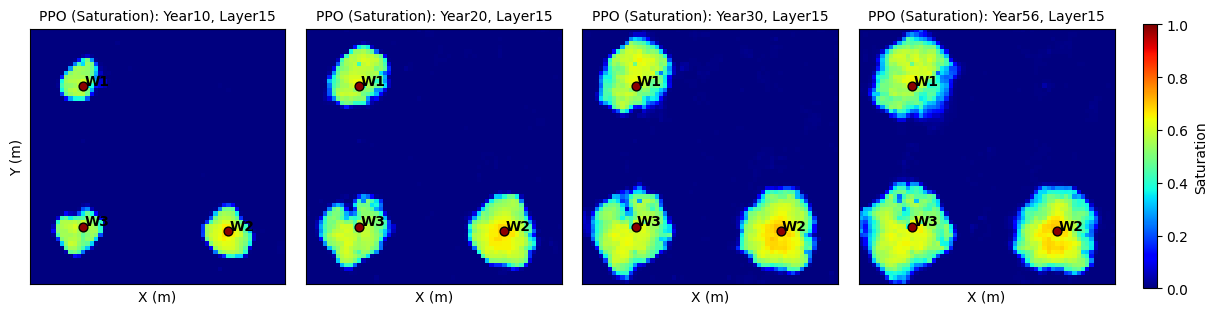

In [22]:
import matplotlib.gridspec as gridspec

# initialize env and PPO once (used by subsequent cells too)
env = CO2StorageEnv(max_time=20,
                    data_path="valid_data.h5",
                    bulk_data_path="BulkVolume.h5",
                    feasible_map_path="robust_feasible_map_3d_gaussian_smoothed.npy")
model = PPO.load("./trained_models/ppo_co2storage_final_seed_1", device="cpu")

def plot_ppo_saturation(env, sample_idx, model, time_steps=[5,10,14,19]):
    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    for step_i in range(env.max_time):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(time_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(time_steps):
        year  = step_to_year[st]
        wlist = wells_list[st]
        ax    = plt.subplot(gs[0, col_i])
        im = ax.imshow(sat_list[st][15], origin="lower", cmap="jet", vmin=0, vmax=1.0)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"PPO: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        if col_i == len(time_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar= fig.colorbar(im, cax=cax)
            cbar.set_label("Saturation", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig11_sat2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
plot_ppo_saturation(env, sample_idx=3, model=model)


# Saturation (CMA-ES): 2D slice at years 10,20,30,56

[(20, 12), (39, 36), (41, 12)]
[(20, 12), (39, 36), (41, 12)]
[(20, 12), (39, 36), (41, 12)]
[(20, 12), (39, 36), (41, 12)]


C:\Users\Labuser\AppData\Local\Temp\ipykernel_3244\2486286770.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


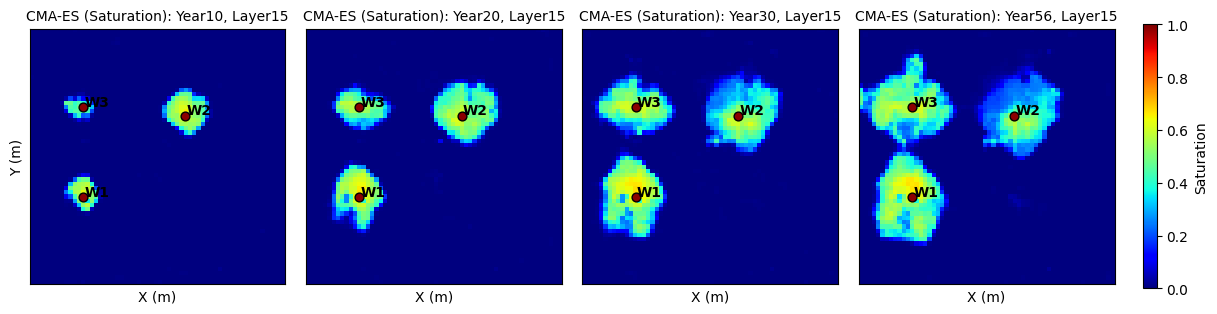

In [23]:
import ast, matplotlib.gridspec as gridspec, matplotlib.pyplot as plt

def vector_to_action_schedule(vec48: np.ndarray):
    v = np.clip(np.asarray(vec48, np.float32), 0.0, 1.0)
    loc_part, rate_parts = v[:6], v[6:].reshape(14,3)
    sched = []
    for t in range(20):
        if t == 0:
            sched.append(np.zeros(9, np.float32))
        elif t == 1:
            sched.append(np.concatenate([loc_part, rate_parts[0]]))
        elif 2 <= t <= 14:
            sched.append(np.concatenate([np.zeros(6, np.float32), rate_parts[t-1]]))
        else:
            sched.append(np.zeros(9, np.float32))
    return sched

def plot_cma_saturation(env, sample_idx, cma_log="cma_live_log.csv"):
    df = pd.read_csv(cma_log)
    row = df[df["Sample"] == sample_idx].iloc[-1]
    genome = np.asarray(ast.literal_eval(row["Genome48"]), dtype=np.float32)

    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    schedule = vector_to_action_schedule(genome)
    for step_i, action in enumerate(schedule):
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    chosen_steps = [5, 10, 14, 19]
    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(chosen_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(chosen_steps):
        year  = step_to_year[st]; wlist = wells_list[st]
        ax = plt.subplot(gs[0, col_i])
        im = ax.imshow(sat_list[st][15], origin="lower", cmap="jet", vmin=0, vmax=1.0)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"CMA-ES: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        if col_i == len(chosen_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar= fig.colorbar(im, cax=cax)
            cbar.set_label("Saturation", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig12_sat2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
plot_cma_saturation(env, sample_idx=3)


# Saturation (best human config): 2D slice at years 10,20,30,56

C:\Users\Labuser\AppData\Local\Temp\ipykernel_3244\3993064015.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


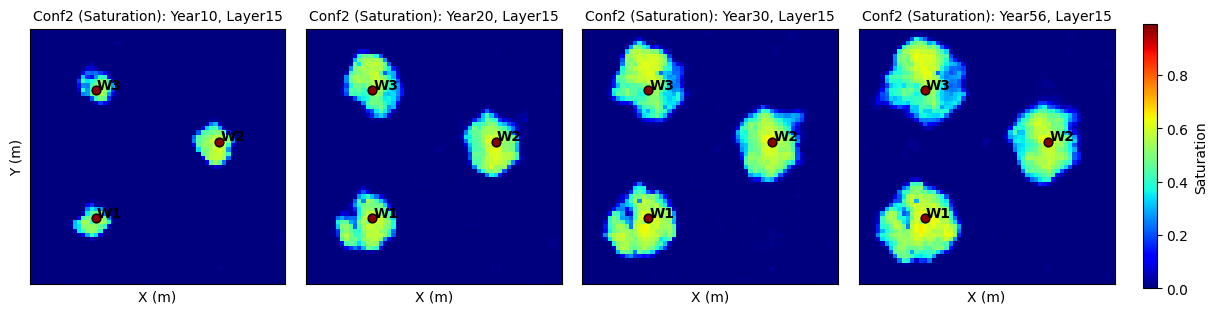

In [13]:
import matplotlib.gridspec as gridspec

def plot_human_config_saturation(env, sample_idx, config, label="Conf2", time_steps=[5,10,14,19]):
    def norm_xy(v, size=60): return v/(size-1)
    (y1,x1), (y2,x2), (y3,x3) = config
    action = np.array([norm_xy(x1), norm_xy(y1),
                       norm_xy(x2), norm_xy(y2),
                       norm_xy(x3), norm_xy(y3),
                       0.33, 0.333, 0.333], dtype=np.float32)

    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    for step_i in range(env.max_time):
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(time_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(time_steps):
        year = step_to_year[st]; wlist = wells_list[st]
        ax   = plt.subplot(gs[0, col_i])
        im = ax.imshow(sat_list[st][15], origin="lower", cmap="jet", vmin=0, vmax=0.99)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"{label}: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        if col_i == len(time_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar= fig.colorbar(im, cax=cax)
            cbar.set_label("Saturation", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig13_sat2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
config_2 = [(15, 15), (44, 33), (15, 45)]
plot_human_config_saturation(env, sample_idx=3, config=config_2, label="Conf2")


# Pressure (PPO): 2D slice at years 10,20,30,56 

Year 10: layer 15 max P = 38821.58984375 MPa
Year 20: layer 15 max P = 39968.06640625 MPa
Year 30: layer 15 max P = 40920.1015625 MPa
Year 56: layer 15 max P = 33222.83984375 MPa


C:\Users\Labuser\AppData\Local\Temp\ipykernel_38644\4138561253.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


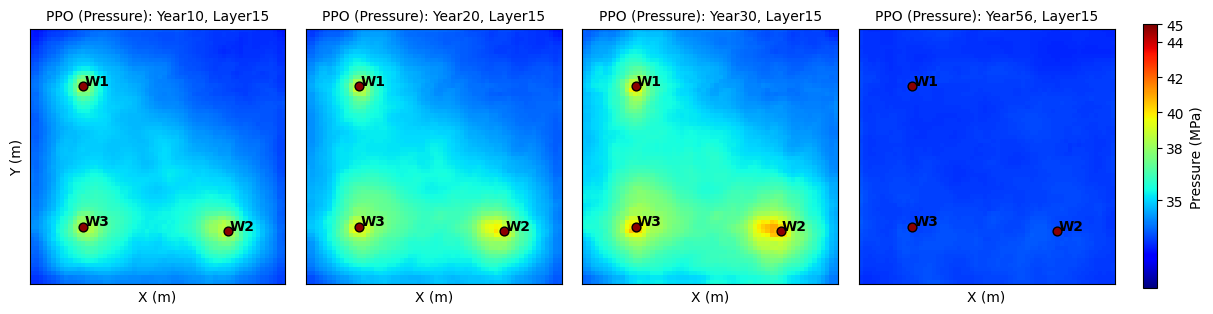

In [13]:
import matplotlib.gridspec as gridspec, matplotlib.pyplot as plt

def plot_ppo_pressure(env, sample_idx, model, time_steps=[5,10,14,19]):
    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    for step_i in range(env.max_time):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(time_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(time_steps):
        year  = step_to_year[st]
        wlist = wells_list[st]
        max_p_mpa = pres_list[st][15].max() / 1000.0
        print(f"Year {year}: layer 15 max P = {max_p_mpa:.1f} MPa")

        ax = plt.subplot(gs[0, col_i])
        im = ax.imshow(pres_list[st][15], origin="lower", cmap="jet", vmin=30000, vmax=45000)  # kPa
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"PPO: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

        if col_i == len(time_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar = fig.colorbar(im, cax=cax)
            ticks_kpa = [35000, 38000, 40000, 42000, 44000, 45000]
            cbar.set_ticks(ticks_kpa)
            cbar.set_ticklabels([t/1000 for t in ticks_kpa])
            cbar.set_label("Pressure (MPa)", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig11_pres2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
plot_ppo_pressure(env, sample_idx=3, model=model)


# Pressure (CMA-ES): 2D slice at years 10,20,30,56

Year 10: layer 15 max P = 38746.40625 MPa
Year 20: layer 15 max P = 38913.4765625 MPa
Year 30: layer 15 max P = 39948.6796875 MPa
Year 56: layer 15 max P = 33146.44921875 MPa


C:\Users\Labuser\AppData\Local\Temp\ipykernel_38644\1252502167.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


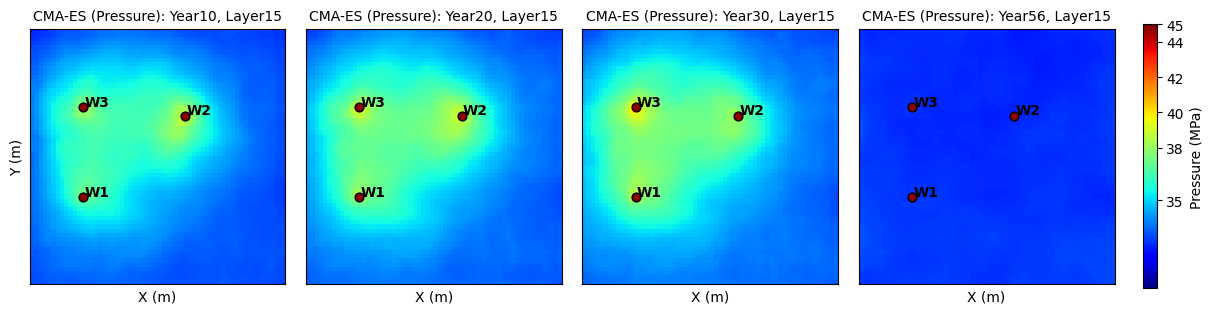

In [14]:
import pandas as pd, numpy as np, ast
import matplotlib.gridspec as gridspec, matplotlib.pyplot as plt

def plot_cma_pressure(env, sample_idx, cma_log="cma_live_log.csv"):
    df = pd.read_csv(cma_log)
    row = df[df["Sample"] == sample_idx].iloc[-1]
    genome = np.asarray(ast.literal_eval(row["Genome48"]), dtype=np.float32)

    sched = vector_to_action_schedule(genome)
    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    for step_i, action in enumerate(sched):
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    chosen_steps = [5, 10, 14, 19]
    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(chosen_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(chosen_steps):
        year = step_to_year[st]; wlist = wells_list[st]
        max_p_mpa = pres_list[st][15].max()/1000.0
        print(f"Year {year}: layer 15 max P = {max_p_mpa:.1f} MPa")

        ax = plt.subplot(gs[0, col_i])
        im = ax.imshow(pres_list[st][15], origin="lower", cmap="jet", vmin=30000, vmax=45000)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"CMA-ES: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

        if col_i == len(chosen_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar= fig.colorbar(im, cax=cax)
            ticks_kpa = [35000, 38000, 40000, 42000, 44000, 45000]
            cbar.set_ticks(ticks_kpa)
            cbar.set_ticklabels([t/1000 for t in ticks_kpa])
            cbar.set_label("Pressure (MPa)", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig12_pres2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
plot_cma_pressure(env, sample_idx=3)


# Pressure (human config): 2D slice at years 10,20,30,56

Year 10: layer 15 max P = 37385.87109375 MPa
Year 20: layer 15 max P = 38007.8359375 MPa
Year 30: layer 15 max P = 38867.65625 MPa
Year 56: layer 15 max P = 33134.83984375 MPa


C:\Users\Labuser\AppData\Local\Temp\ipykernel_38644\2087965560.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


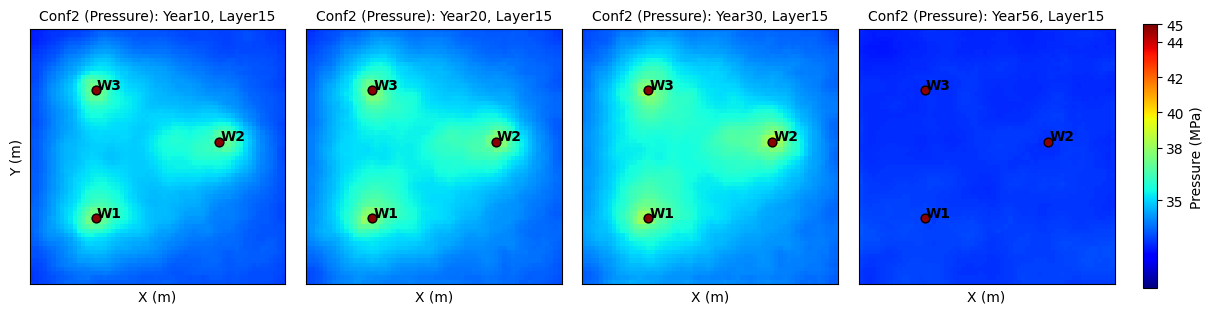

In [15]:
import matplotlib.gridspec as gridspec, matplotlib.pyplot as plt

def plot_human_config_pressure(env, sample_idx, config, label="Conf2", time_steps=[5,10,14,19]):
    def norm_xy(v, size=60): return v/(size-1)
    (y1,x1), (y2,x2), (y3,x3) = config
    action = np.array([norm_xy(x1), norm_xy(y1),
                       norm_xy(x2), norm_xy(y2),
                       norm_xy(x3), norm_xy(y3),
                       (1.0-0.5)/1.5, (1.0-0.5)/1.5, (1.0-0.5)/1.5], dtype=np.float32)

    obs = env.reset(sample_idx=sample_idx)
    sat_list, pres_list, wells_list = [], [], []
    for step_i in range(env.max_time):
        obs, reward, done, info = env.step(action)
        sat_list.append(env.state["sat"].copy())
        pres_list.append(env.state["pressure"].copy())
        wells_list.append(info["well_locations"])
        if done:
            for _ in range(step_i+1, env.max_time):
                sat_list.append(env.state["sat"].copy())
                pres_list.append(env.state["pressure"].copy())
                wells_list.append(info["well_locations"])
            break

    step_to_year = {5:10, 10:20, 14:30, 19:56}
    well_labels  = ["W1","W2","W3"]

    fig = plt.figure(figsize=(14, 4.2))
    gs  = gridspec.GridSpec(1, len(time_steps), wspace=0.08, hspace=0.15)
    for col_i, st in enumerate(time_steps):
        year = step_to_year[st]; wlist = wells_list[st]
        max_p_mpa = pres_list[st][15].max()/1000.0
        print(f"Year {year}: layer 15 max P = {max_p_mpa:.1f} MPa")

        ax = plt.subplot(gs[0, col_i])
        im = ax.imshow(pres_list[st][15], origin="lower", cmap="jet", vmin=30000, vmax=45000)
        if wlist:
            for wi, wc in enumerate(wlist):
                if wc is None: continue
                wy, wx = wc
                ax.scatter(wx, wy, s=40, color="darkred", edgecolor="black")
                ax.text(wx+0.3, wy+0.3, well_labels[wi], fontsize=10, fontweight='bold')
        ax.set_title(f"{label}: Year {year}, Layer 15", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

        if col_i == len(time_steps)-1:
            cax = fig.add_axes([0.92, 0.25, 0.012, 0.5])
            cbar= fig.colorbar(im, cax=cax)
            ticks_kpa = [35000, 38000, 40000, 42000, 44000, 45000]
            cbar.set_ticks(ticks_kpa)
            cbar.set_ticklabels([t/1000 for t in ticks_kpa])
            cbar.set_label("Pressure (MPa)", fontsize=10)

    plt.tight_layout()
    plt.savefig("Figures/Fig13_pres2d.png", dpi=300, bbox_inches="tight")
    plt.show()

# example
plot_human_config_pressure(env, sample_idx=3, config=config_2, label="Conf2")


# rate history (PPO vs best-human vs CMA-ES)

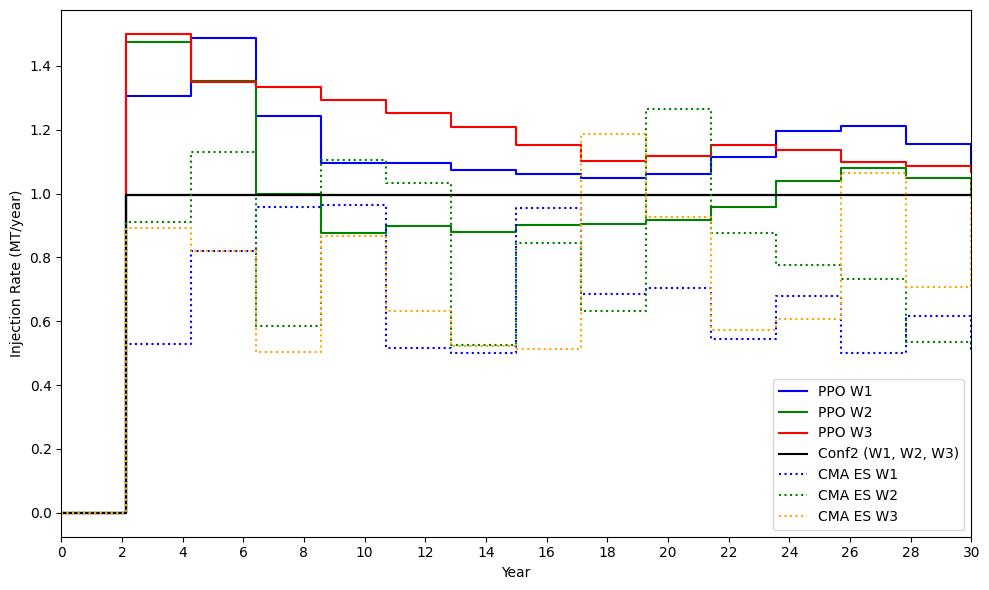

In [21]:
# 0..30 years (injection). PPO and CMA-ES come from their logs; “best human”
# is a per-timepoint for Config2. Units are Mt/year.

import ast, matplotlib.pyplot as plt

df_detail = pd.read_csv("detail.csv")
sample_idx = 3

# PPO rates
ppo_steps = df_detail[(df_detail["SampleIndex"]==sample_idx) & (df_detail["Approach"]=="PPO")]
ppo_rate_rows = ppo_steps["RealRates"].apply(ast.literal_eval)
ppo_r1, ppo_r2, ppo_r3 = zip(*ppo_rate_rows)
ppo_time = ppo_steps["Timestep"] - 1

inj_period_steps = 14
last_year = 30
scale = last_year / inj_period_steps

def trim_at_30(xvals, yvals):
    out_x, out_y = [], []
    for x, y in zip(xvals, yvals):
        if x < 30: out_x.append(x); out_y.append(y)
        elif x == 30: out_x.append(x); out_y.append(y); break
        else: break
    return out_x, out_y

px = list(ppo_time * scale)
p1, p2, p3 = list(ppo_r1), list(ppo_r2), list(ppo_r3)
px, p1 = trim_at_30(px, p1); _, p2 = trim_at_30(px, p2); _, p3 = trim_at_30(px, p3)

# Best-of-human (Conf1..Conf3) elementwise per time
human_well_rates = {1: [], 2: [], 3: []}
human_times = []
for t in sorted(df_detail[df_detail["SampleIndex"]==sample_idx]["Timestep"].unique()):
    rates = []
    for conf in ["Conf1","Conf2","Conf3"]:
        row = df_detail[(df_detail["SampleIndex"]==sample_idx) &
                        (df_detail["Approach"]==conf) &
                        (df_detail["Timestep"]==t)]
        if not row.empty:
            rates.append(ast.literal_eval(row["RealRates"].values[0]))
    if rates:
        best = np.max(rates, axis=0)
        for wi in range(3): human_well_rates[wi+1].append(best[wi])
        human_times.append(t)

hx = (np.array(human_times) - 1) * scale
hx = np.insert(hx, 0, 0.0)
for wi in range(1,4):
    human_well_rates[wi] = [0.0] + human_well_rates[wi]

hx, h1 = trim_at_30(hx, human_well_rates[1]); _, h2 = trim_at_30(hx, human_well_rates[2]); _, h3 = trim_at_30(hx, human_well_rates[3])

# CMA-ES (decode genome → physical rates)
df_cma = pd.read_csv("cma_live_log.csv")
row = df_cma[df_cma["Sample"] == sample_idx].iloc[-1]
genome = np.asarray(ast.literal_eval(row["Genome48"]), dtype=np.float32)
PHYS = lambda r: 0.5 + 1.5*r
rates_phys = PHYS(genome[6:].reshape(14,3))
cx = np.arange(1, 15) * scale
cx = np.insert(cx, 0, 0.0)
c1 = np.insert(rates_phys[:,0], 0, 0.0)
c2 = np.insert(rates_phys[:,1], 0, 0.0)
c3 = np.insert(rates_phys[:,2], 0, 0.0)
cx, c1 = trim_at_30(cx, c1); _, c2 = trim_at_30(cx, c2); _, c3 = trim_at_30(cx, c3)

plt.figure(figsize=(10,6))
# PPO
plt.step(px, p1, where="post", label="PPO W1")
plt.step(px, p2, where="post", label="PPO W2")
plt.step(px, p3, where="post", label="PPO W3")
# Best human (Conf1..Conf3)
plt.step(hx, h1, where="post", label="Best Human W1", linestyle="-")
plt.step(hx, h2, where="post", label="Best Human W2", linestyle="-")
plt.step(hx, h3, where="post", label="Best Human W3", linestyle="-")
# CMA-ES
plt.step(cx, c1, where="post", label="CMA-ES W1", linestyle=":")
plt.step(cx, c2, where="post", label="CMA-ES W2", linestyle=":")
plt.step(cx, c3, where="post", label="CMA-ES W3", linestyle=":")

plt.xlabel("Year"); plt.ylabel("Injection Rate (Mt/year)")
plt.xticks(range(0,31,2)); plt.xlim(0,30)
plt.legend(); plt.tight_layout()
plt.savefig("Figures/Fig14.png", dpi=600, bbox_inches="tight")
plt.show()


# PPO vs CMA-ES time-profiles (Reward, Mass, Pressure, Leakage)

C:\Users\Labuser\Desktop\Please Dont Delete this Folder Gamze\surrogate_model_gru.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model

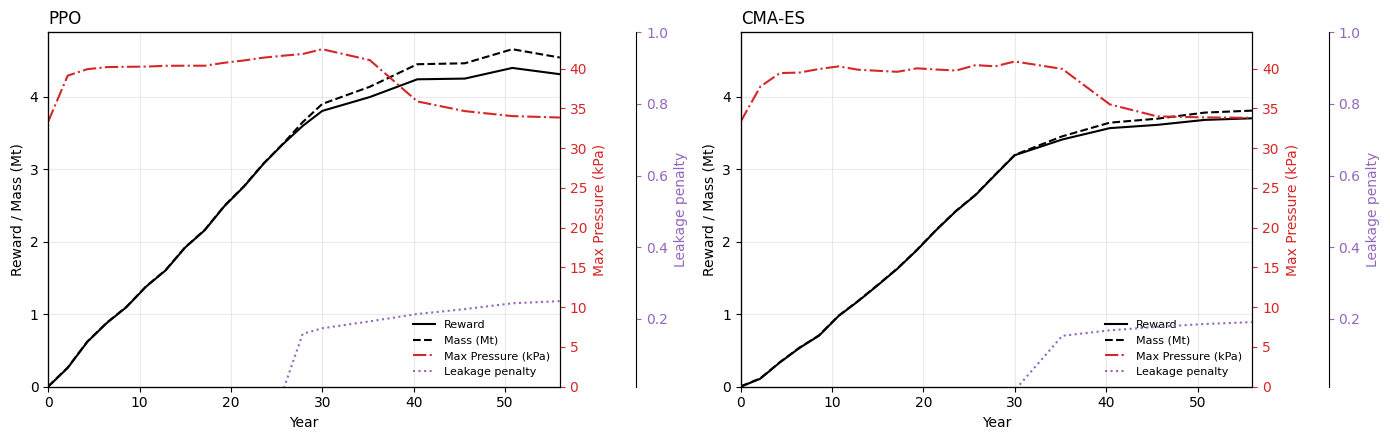

In [24]:
# Replays PPO and CMA-ES schedules on the SAME sample and tracks cumulative reward,
# stored mass in place (Mt), max pressure (MPa), and leakage penalty over 56 years.

import numpy as np, pandas as pd, ast, matplotlib.pyplot as plt

SAMPLE          = 3
PPO_MODEL_PATH  = "./trained_models/ppo_co2storage_final_seed_10"
CMA_LOG_CSV     = "cma_live_log.csv"
YEAR_END_INJ    = 30.0
YEAR_FINAL      = 56.0
DEVICE          = "cpu"

INJECT_LAST = 14
step_to_year = lambda s: (s/INJECT_LAST)*YEAR_END_INJ if s<=INJECT_LAST \
                         else YEAR_END_INJ + (s-INJECT_LAST)*(YEAR_FINAL-YEAR_END_INJ)/(19-INJECT_LAST)

def reset_to_sample(env, idx):
    for _ in range(9999):
        env.reset()
        if env.sample_idx == idx: return
    raise RuntimeError("Could not reset to desired sample index")

def collect_episode(env, act_fn):
    reset_to_sample(env, SAMPLE)
    obs = env._build_observation()
    yrs, rew, mass, pres_mpa, leak = [], [], [], [], []
    cumR = 0.0
    while True:
        s   = env.current_step
        act = act_fn(s, obs)
        obs, r, done, info = env.step(act)
        cumR += r
        yrs.append(step_to_year(s))
        rew.append(cumR)
        mass.append(env.last_mass_in_place)          # Mt (per env)
        pres_mpa.append(info["max_pressure"]/1e3)    # MPa
        leak.append(info["leakage_penalty"])
        if done: break
    return map(np.asarray, (yrs, rew, mass, pres_mpa, leak))

# fresh envs (VALID split)
kw = dict(data_path="valid_data.h5",
          bulk_data_path="BulkVolume.h5",
          feasible_map_path="robust_feasible_map_3d_gaussian_smoothed.npy",
          max_time=20)
ppo_env = CO2StorageEnv(**kw)
cma_env = CO2StorageEnv(**kw)

# PPO rollout
ppo_model = PPO.load(PPO_MODEL_PATH, device=DEVICE)
ppo_data  = tuple(collect_episode(ppo_env, lambda _,ob: ppo_model.predict(ob, deterministic=True)[0]))

# CMA-ES best-reward schedule
df = pd.read_csv(CMA_LOG_CSV)
best_vec = np.asarray(ast.literal_eval(
              df[df["Sample"]==SAMPLE].sort_values("Reward", ascending=False).iloc[0]["Genome48"]
          ), np.float32)
loc, rates = best_vec[:6], best_vec[6:].reshape(14,3)
sched = [np.zeros(9,np.float32)]
sched += [np.concatenate([loc, rates[0]])]
sched += [np.concatenate([np.zeros(6,np.float32), r]) for r in rates[1:]]
sched += [np.zeros(9,np.float32)]*5
cma_data = tuple(collect_episode(cma_env, lambda s,_: sched[s]))

YL_RM   = (0, 1.05*np.hstack([ppo_data[1], ppo_data[2], cma_data[1], cma_data[2]]).max())
YL_PRES = (0, 1.05*np.hstack([ppo_data[3], cma_data[3]]).max())
YL_LEAK = (0.01, 1.0)

COL = dict(rew="black", mass="black", pres="tab:red", leak="tab:purple")

def add_leak_axis(ax, offset=55):
    la = ax.twinx()
    la.spines.right.set_position(("outward", offset))
    la.spines.right.set_visible(True)
    return la

def panel(ax, data, title):
    yrs, rew, mass, pres_mpa, leak = data
    ax.plot(yrs, rew,  label="Reward",    color=COL["rew"])
    ax.plot(yrs, mass, label="Mass (Mt)", color=COL["mass"], ls="--")
    ax.set_xlim(0, YEAR_FINAL); ax.set_ylim(*YL_RM)
    ax.set_xlabel("Year"); ax.set_ylabel("Reward / Mass (Mt)")
    # pressure (MPa)
    p_ax = ax.twinx()
    p_ax.plot(yrs, pres_mpa, label="Max Pressure (MPa)", color=COL["pres"], ls="-.")
    p_ax.set_ylim(*YL_PRES)
    p_ax.set_ylabel("Max Pressure (MPa)", color=COL["pres"])
    p_ax.tick_params(axis='y', colors=COL["pres"])
    # leakage
    l_ax = add_leak_axis(ax)
    l_ax.plot(yrs, leak, label="Leakage penalty", color=COL["leak"], ls=":")
    l_ax.set_ylim(*YL_LEAK)
    l_ax.set_ylabel("Leakage penalty", color=COL["leak"])
    l_ax.tick_params(axis='y', colors=COL["leak"])
    # shared legend
    h,l = [],[]
    for axis in (ax,p_ax,l_ax):
        hi,li = axis.get_legend_handles_labels(); h+=hi; l+=li
    ax.legend(h,l, loc="lower right", fontsize=8, frameon=False)
    ax.grid(alpha=0.25); ax.set_title(title, loc="left")

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,4.5))
panel(ax1, ppo_data, "PPO")
panel(ax2, cma_data, "CMA-ES")
plt.tight_layout()
plt.savefig("Figures/Fig16.png", dpi=600, bbox_inches="tight")
plt.show()
